<a href="https://colab.research.google.com/github/umbertogagl97/Tesi/blob/main/Addestramento_scanner_Pytorch(Test_votazione).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Init**

## Import librerie

In [ ]:
#Librerie

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import time
import os
import shutil
import copy


##Check device


In [ ]:
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

1.9.0+cu111
True
Tesla P100-PCIE-16GB
cuda:0


##Def path

In [ ]:
#scanner
scanner_name = 'DigitalPersona'

#salvataggio modello
model_save_name = 'VGG19_paper_30epoc_93val_84test'
path_model_save = F"/content/gdrive/My Drive/ModelliCNN/Scanner/{scanner_name}/Pytorch/{model_save_name}" 

#dataset
pathDataset=F'/content/gdrive/MyDrive/Dataset_impronte/training/{scanner_name}_patch'
pathTestset=F'/content/gdrive/MyDrive/Dataset_impronte/test/{scanner_name}'

##Collegamento google drive

In [ ]:
#collegamento google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


#**Dataset**

##Caricamento dataset e creazione Dataloader

In [ ]:
import torch
import torchvision
from torchvision import transforms

data_transform=transforms.Compose([transforms.Resize([224,224]),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])


train_dataset = datasets.ImageFolder(pathDataset,transform=data_transform)

In [ ]:
print(len(train_dataset))

20000


##Nomi classi

In [ ]:
classes_name=train_dataset.classes
class_number=len(classes_name)
print(classes_name)
print(class_number)

['Live', 'Spoof']
2


# **Creazione modello**

##Load model pre-trained

In [ ]:
model_conv = models.vgg19(pretrained=True,progress=True)
for param in model_conv.parameters():
  param.requires_grad = False #non modifico i parametri della parte riguardante le features durante il training, poiché voglio usare quella parte così com'è stata pre-addestrata

print(model_conv)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

##Aggiunta classificatore e freeze parametri

In [ ]:
model_conv.classifier[6]=nn.Linear(4096,2)

for param in model_conv.classifier.parameters():
  param.requires_grad = True #invece pongo il calcolo del gradiente del classificatore, ovvero attivo il calcolo dei pesi

print(model_conv) 

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

##Load pesi

In [ ]:
best_model=model_conv
best_model.load_state_dict(torch.load(path_model_save,map_location=torch.device('cpu')))


<All keys matched successfully>

#**Training**

##Def train definitiva

In [ ]:
from collections import OrderedDict
from functools import partial
import sys

import numpy as np
import sys
import torch

from functools import partial
from torch.utils.data import DataLoader, TensorDataset


##### Data utils #####

def log_to_message(log):
    fmt = "{0}: {1}"
    return "    ".join(fmt.format(k, v) for k, v in log.items())


class ProgressBar(object):
    """Cheers @ajratner"""

    def __init__(self, n, length=40):
        # Protect against division by zero
        self.n      = max(1, n)
        self.nf     = float(n)
        self.length = length
        # Precalculate the i values that should trigger a write operation
        #self.ticks = set([round(i/100.0 * n) for i in range(101)])
        #self.ticks.add(n-1)
        self.ticks=range(n)
        self.bar(0)

    def bar(self, i, message=""):
        """Assumes i ranges through [0, n-1]"""
        if i in self.ticks:
            b = int(np.ceil(((i+1) / self.nf) * self.length))
            sys.stdout.write("\r[{0}{1}] {2}%\t{3}".format(
                "="*b, " "*(self.length-b), int(100*((i+1) / self.nf)), message
            ))
            sys.stdout.flush()

    def close(self, message=""):
        # Move the bar to 100% before closing
        self.bar(self.n-1)
        sys.stdout.write("{0}\n\n".format(message))
        sys.stdout.flush()



def training_f(train_dataset, numEpochs, model_conv, criterionCNN, optimizer_conv,batch_size, validation_split=0):
  
  best_acc = 0
  best_loss=0
  best_epoca = 0
  
  best_model_wts = copy.deepcopy(model_conv.state_dict())

  if validation_split:
      train_size = int(len(train_dataset) * 0.8)
      val_size = len(train_dataset) - train_size
      train_dataset, val_set = torch.utils.data.random_split(train_dataset, [train_size, val_size])
      traingen = torch.utils.data.DataLoader(train_dataset, pin_memory=True, batch_size=batch_size, shuffle=True,num_workers=2)
      valgen = torch.utils.data.DataLoader(val_set, pin_memory=True, batch_size=batch_size)
  
  else: traingen = torch.utils.data.DataLoader(train_dataset, pin_memory=True, batch_size=batch_size, shuffle=True,num_workers=2)
      
  for epochs in range(1,numEpochs + 1):
    
    print("Epoch {0} / {1}".format(epochs, numEpochs))
    log = OrderedDict()
    modelLoss_train = 0.0
    modelAcc_train = 0.0
    
    model_conv.train() 
    
    totalSize = 0
    batch_i=0
    num_batch=int(np.ceil(len(train_dataset)/batch_size))
    pb = ProgressBar(num_batch)
    #for each batch: operazioni per gli algoritmi di ottimizzazione
    for inputs,labels in traingen:
      inputs = inputs.type(torch.FloatTensor).cuda()
      labels = labels.cuda()
      
      batch_i=batch_i+1
      
      optimizer_conv.zero_grad()
      model_conv.zero_grad()
      
      y = model_conv(inputs)
      outp, preds = torch.max(y, 1)   
        
      lossCNN = criterionCNN(y, labels) #media per batch

      modelLoss_train += lossCNN.item() * inputs.size(0)
      totalSize += inputs.size(0)
      modelAcc_train += torch.sum(preds == labels.data).item()

      log['batch']="{0} / {1}".format(batch_i, num_batch)
      log['loss'] =round(modelLoss_train/totalSize,4)
      log['acc']=round(modelAcc_train/totalSize,4)
      log['Validation']=False
      pb.bar(batch_i, log_to_message(log))

      lossCNN.backward()  # pred = f(x)   -> loss = L(f(x), l_true)
      
      optimizer_conv.step()
    
    #calcolo loss e accuracy
    modelLoss_epoch_train = modelLoss_train/totalSize
    modelAcc_epoch_train  = modelAcc_train/totalSize
    
    log['loss']=round(modelLoss_epoch_train,2)
    log['acc']=round(modelAcc_epoch_train*100,2)
    pb.bar(num_batch-1, log_to_message(log))

    if validation_split:    
        #validation
               
        model_conv.eval()
        totalSize_val = 0
        modelLoss_val = 0.0
        modelAcc_val = 0.0

        log['Validation']=True
        log['loss_val']=modelLoss_val
        log['acc_val']=modelAcc_val
        pb.bar(num_batch-1, log_to_message(log))
        batch_val_i=0
        size_valgen=len(valgen)
        for inputs,labels in valgen:
          inputs = inputs.type(torch.FloatTensor).cuda()
          labels = labels.cuda()
          batch_val_i+=1
          y = model_conv(inputs)
          outp, preds = torch.max(y, 1)
          lossCNN = criterionCNN(y, labels)

          modelLoss_val += lossCNN.item() * inputs.size(0)
          totalSize_val += inputs.size(0)
          modelAcc_val += torch.sum(preds == labels.data).item()        

          log['batch_val']="{0} / {1}".format(batch_val_i,size_valgen )
          log['loss_val'] =round(modelLoss_val/totalSize_val,4)
          log['acc_val']=round(modelAcc_val/totalSize_val,4)
          pb.bar(num_batch-1, log_to_message(log))

        modelLoss_epoch_val=modelLoss_val/totalSize_val
        modelAcc_epoch_val = modelAcc_val/totalSize_val

        log['loss_val'] =round(modelLoss_epoch_val,2)
        log['acc_val']=round(modelAcc_epoch_val*100,2)
        
        if (modelAcc_epoch_val > best_acc) or (modelAcc_epoch_val == best_acc and modelLoss_epoch_val < best_loss) :
          best_acc = modelAcc_epoch_val
          best_loss = modelLoss_epoch_val
          best_epoca = epochs
          best_model_wts = copy.deepcopy(model_conv.state_dict()) #salvo come modello quello che mi ha restituito risultati migliori in validation
          
        pb.close(log_to_message(log))

    else: 
      best_model_wts = copy.deepcopy(model_conv.state_dict())
      pb.close(log_to_message(log))

    with open('lossTrain.txt', "a") as file_object:
      file_object.write(str(modelLoss_epoch_train) +'\n')
      
    with open('AccTrain.txt', "a") as file_object:
      file_object.write(str(modelAcc_epoch_train)+'\n')
      
    with open('lossVal.txt', "a") as file_object:
      file_object.write(str(modelLoss_epoch_val)+'\n')
      
    with open('AccVal.txt', "a") as file_object:
      file_object.write(str(modelAcc_epoch_val)+'\n')

  #pb.close(log_to_message(log))

  model_conv.load_state_dict(best_model_wts)
  return model_conv




##Set iperparametri

In [ ]:
#iper-parametri iniziali
learning_rate = 1e-2
momentum=0.5
num_epoch = 5
batch_size = 200
#richiamo funzione che effettua il training con validation

model_conv = model_conv.cuda() #sposta i calcoli sulla gpu
criterion = nn.CrossEntropyLoss() #criterio dell'aggiornamento del gradiente: minimizzazione funzione loss entropia
optimizer_conv = optim.SGD(model_conv.classifier.parameters(),lr=learning_rate,momentum=momentum)

##Addestramento

In [ ]:
best_model=training_f(train_dataset, num_epoch, model_conv, criterion, optimizer_conv,batch_size=batch_size)#, validation_split=0.2)

Epoch 1 / 100
[========================================] 100%	batch: 3200 / 3200    loss: 0.59    acc: 68.23    Validation: True    loss_val: 0.48    acc_val: 82.0    batch_val: 800 / 800

Epoch 2 / 100
[========================================] 100%	batch: 3200 / 3200    loss: 0.46    acc: 80.17    Validation: True    loss_val: 0.41    acc_val: 85.58    batch_val: 800 / 800

Epoch 3 / 100
[========================================] 100%	batch: 3200 / 3200    loss: 0.41    acc: 83.12    Validation: True    loss_val: 0.36    acc_val: 86.48    batch_val: 800 / 800

Epoch 4 / 100
[========================================] 100%	batch: 3200 / 3200    loss: 0.37    acc: 84.86    Validation: True    loss_val: 0.33    acc_val: 87.85    batch_val: 800 / 800

Epoch 5 / 100
[========================================] 100%	batch: 3200 / 3200    loss: 0.35    acc: 85.95    Validation: True    loss_val: 0.31    acc_val: 88.0    batch_val: 800 / 800

Epoch 6 / 100
[=====================================

#**Testing**

##Test

In [ ]:
def calc_size(n):
  return tuple(int(np.ceil(i * (80/100))) for i in n)

In [ ]:
from PIL import Image
import pandas as pd

#best_model=model_conv
Test = pd.DataFrame()
best_model.eval()
best_model.cuda()

data_transform_test= transforms.Compose([transforms.Resize([224,224]),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

Directory = os.listdir(pathTestset)
for classe in Directory:
  classes_path = os.listdir(pathTestset +"/"+ classe)  
  print(classe)
  for input in classes_path:
    if (input.endswith('.png') or input.endswith('.bmp')):  
      img = Image.open(pathTestset+"/"+classe+'/' + input)
      n=img.size
      n_mod=calc_size(n)
      crop_transform=transforms.TenCrop((n_mod[1],n_mod[0])).to(device)
      crops=crop_transform(img)
            
      live=0
      spoof=0
      for crop in crops:
        crop=data_transform_test(crop).to(device)
        crop=crop.unsqueeze_(0)
        outputs = best_model(crop)
        live+=outputs[0][0]
        spoof+=outputs[0][1]
      live=live/10
      spoof=spoof/10
      predicted=np.argmax([live,spoof])
      Test = Test.append({'img': input.split('.')[0],
                          'predicted': classes_name[predicted],
                          'real': classe} ,ignore_index = True) 


Spoof


In [ ]:
true_label = Test.real.values
predicted = Test.predicted.values

print(round((np.sum((true_label == predicted).astype(int)))/Test.shape[0],4)*100)
#84,8

84.68


In [ ]:
print(Test.shape)

(2500, 3)


#**Salvataggio modello**

In [ ]:
#salva modello su drive
torch.save(best_model.state_dict(),path_model_save)

#Plot delle curve

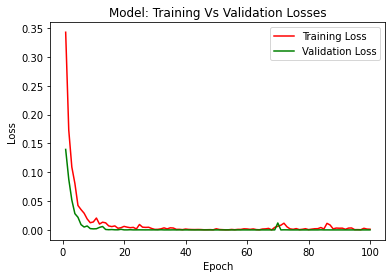

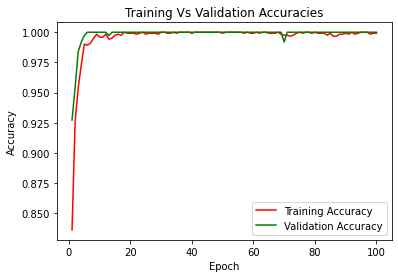

In [ ]:
import matplotlib.pyplot as plt

lossModel_Train = []
lossModel_val = []
accModel_Train = []
accModel_val = []

file = open('lossTrain.txt', 'r')
Testo = file.readlines()
for element in Testo:
  lossModel_Train.append(float(element))

file = open('lossVal.txt', 'r')
Testo = file.readlines()
for element in Testo:
  lossModel_val.append(float(element))

plt.figure()
plt.title("Model: Training Vs Validation Losses")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(list(range(1,len(lossModel_Train)+1)), lossModel_Train, color='r', label="Training Loss")
plt.plot(list(range(1, len(lossModel_val)+1)), lossModel_val, color='g', label="Validation Loss")
plt.legend()
plt.savefig('LossTrainVal.png')

file = open('AccTrain.txt', 'r')
Testo = file.readlines()
for element in Testo:
  accModel_Train.append(float(element))

file = open('AccVal.txt', 'r')
Testo = file.readlines()
for element in Testo:
  accModel_val.append(float(element))

plt.figure()
plt.title("Training Vs Validation Accuracies")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(list(range(1, len(accModel_Train)+1)), accModel_Train, color='r', label="Training Accuracy")
plt.plot(list(range(1, len(accModel_val)+1)), accModel_val, color='g', label="Validation Accuracy")
plt.legend()
plt.savefig(WeightPath + 'AccTrainVal.png')

#Mat conf

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

c = confusion_matrix(true_label,predicted, labels=['Live','Spoof'])
df_cm = pd.DataFrame(c , index = [i for i in list(range(1,3))],
                  columns = [i for i in list(range(1,3))])
plt.figure(figsize = (2,2))
sn.heatmap(df_cm, annot=True)